In [3]:
print('Notebook working well lol this is good enough for me')

Notebook working well lol this is good enough for me


In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
housing = pd.read_csv('/Users/arjun/Documents/HandsOnMachineLearningStudy/Chapter 2/datasets/housing/housing.csv')

In [10]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])

<Axes: >

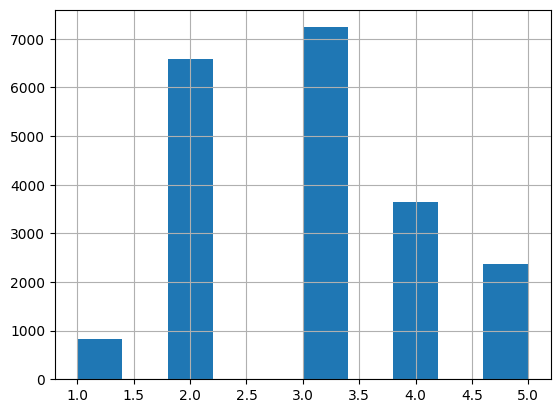

In [12]:
housing['income_cat'].hist()

In [13]:
!pip3 install scikit-learn 

  Using cached scipy-1.14.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 14.1 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.0-cp312-cp312-macosx_14_0_arm64.whl (23.1 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [18]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [19]:
housing_num = housing.select_dtypes(include=[np.number])

In [20]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [21]:
X = imputer.transform(housing_num)

In [22]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [23]:
housing_cat = housing[["ocean_proximity"]]

In [24]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [25]:
housing_catt = encoder.fit_transform(housing_cat)

In [27]:
housing_catt.toarray()


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room == True:
            bedrooms_per_rooms  = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household,population_per_household]

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [38]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [41]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [42]:
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [44]:
from sklearn.metrics import mean_squared_error

preds = lin_reg.predict(housing_prepared)

mse = mean_squared_error()


In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg,housing_prepared, housing_labels, cv=10 )

In [48]:
np.mean(scores)

np.float64(0.6515472364776758)

In [49]:
# Excercise 1:
# Try a SVM

In [50]:
from sklearn.svm import SVR

svmm = SVR(kernel='linear')
svmm.fit(housing_prepared, housing_labels)


SVR(kernel='linear')

In [52]:
scores = cross_val_score(svmm, housing_prepared, housing_labels[:16512+3000], cv=3)


In [53]:
np.mean(scores)

np.float64(0.03933659683163674)

In [61]:
svmm.predict(housing_prepared)

array([172101.40186394, 193501.77218967, 166494.54563559, ...,
       183149.08001475, 186142.62424062, 165375.34699964])

In [62]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

In [63]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(110578.44384464293)

In [65]:
forest_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=3)


In [66]:
forest_scores

array([-114296.02897603, -112203.42244745, -112526.59528959])

In [67]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'kernel':['linear'], 'C':[100, 400, 700, 1000]},
    {'kernel':['rbf'], 'C':[100,400,700,1000], 'gamma':[0.001,0.003,0.005,0.009]}
]

svmm = SVR()
grid_search = GridSearchCV(svmm, param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)

In [68]:
train = housing_prepared[:5000]

In [72]:
labels = housing_labels[:5000]

In [73]:
grid_search.fit(train,labels)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [100, 400, 700, 1000], 'kernel': ['linear']},
                         {'C': [100, 400, 700, 1000],
                          'gamma': [0.001, 0.003, 0.005, 0.009],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [74]:
grid_search.best_params_

{'C': 1000, 'kernel': 'linear'}

In [75]:
grid_search.cv_results_

{'mean_fit_time': array([0.32202856, 0.37831839, 0.48210239, 0.33426372, 0.38984021,
        0.40414937, 0.34963163, 0.34626238, 0.32312973, 0.31438057,
        0.31871104, 0.31918788, 1.54738124, 0.34722511, 0.31821108,
        0.37225072, 0.31888541, 0.32919701, 0.32056006, 0.31402763]),
 'std_fit_time': array([9.29837956e-02, 1.00187726e-01, 1.79438421e-01, 1.04791297e-01,
        1.09193877e-01, 7.36352306e-02, 2.07318895e-02, 3.45631546e-02,
        4.12598309e-03, 3.11572800e-03, 4.23367579e-03, 7.90506440e-04,
        1.07329579e+00, 3.04121071e-02, 1.29042114e-03, 7.61341787e-02,
        1.43363131e-03, 1.14237158e-02, 4.85881545e-03, 1.78838688e-03]),
 'mean_score_time': array([0.10363245, 0.09610995, 0.09767826, 0.06967839, 0.29466859,
        0.35372933, 0.28756166, 0.27705065, 0.27408059, 0.27897406,
        0.27932692, 0.2754101 , 0.81841238, 0.35488073, 0.28597967,
        0.28949833, 0.27964671, 0.27620236, 0.28387117, 0.27734645]),
 'std_score_time': array([5.24692391e-

In [76]:
import pandas as pd

# Convert cv_results_ to a DataFrame for easier inspection
results = pd.DataFrame(grid_search.cv_results_)

# Get the best parameters for the linear kernel
linear_results = results[results['param_kernel'] == 'linear']
best_linear_params = linear_results.loc[linear_results['mean_test_score'].idxmax()]['params']

# Get the best parameters for the rbf kernel
rbf_results = results[results['param_kernel'] == 'rbf']
best_rbf_params = rbf_results.loc[rbf_results['mean_test_score'].idxmax()]['params']

print("Best parameters for linear kernel:", best_linear_params)
print("Best parameters for rbf kernel:", best_rbf_params)


Best parameters for linear kernel: {'C': 1000, 'kernel': 'linear'}
Best parameters for rbf kernel: {'C': 1000, 'gamma': 0.009, 'kernel': 'rbf'}


In [80]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distribs = [
    {'kernel': ['linear'], 'C': randint(100, 1001)},
    {'kernel': ['rbf'], 'C': randint(100, 1001), 'gamma': uniform(0.001, 0.009)}
]


In [81]:
rnd_search = RandomizedSearchCV(svmm,param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_mean_squared_error')

In [82]:
rnd_search.fit(train,labels)

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x126aed730>,
                                         'kernel': ['linear']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12776f0e0>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12776fda0>,
                                         'kernel': ['rbf']}],
                   scoring='neg_mean_squared_error')

In [87]:
rnd_search.best_params_

{'C': 913, 'kernel': 'linear'}

In [89]:
final_model = rnd_search.best_estimator_

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [93]:
X = strat_test_set.drop('median_house_value', axis=1)

In [94]:
y = strat_test_set['median_house_value'].copy()

In [95]:
y

3905     397700.0
16821    202900.0
2900     310000.0
7193     314300.0
13928    187500.0
           ...   
12369     90600.0
8707      59400.0
16634    246200.0
9779     214700.0
3455     163400.0
Name: median_house_value, Length: 4128, dtype: float64

In [96]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,NEAR BAY
...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,NEAR OCEAN
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,INLAND
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,<1H OCEAN
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,NEAR BAY


In [97]:
X_prepared = full_pipeline.transform(X)

In [98]:
final_predictions = final_model.predict(X_prepared)


In [99]:
final_mse = mean_squared_error(y, final_predictions)
final_rmse = np.sqrt(final_mse)

In [100]:
final_rmse

np.float64(216949.0277951229)